# Multiple and Polynomial Regression from scratch

## Objective:

The goal is to create median house price estimator for Boston city, using a Multiple Linear Regression Model build from scratch, applied on the "Boston Housing Dataset". Then I will try to improve this estimator, using a Multiple Polynomial Regression Model.<br/>

I won't explain theory here, only background basic equations needed for code understanding.

![Alt Text](img/animation.gif)

---

## Table of contents

1. Dataset
2. Multiple Linear model definition
3. Loss function definition
4. Gradient definition
5. Gradient descent algorithm
6. Training the model on data
7. Model evaluation
8. Multiple Polynomial Regression
9. Median houses prices Estimations
10. Conclusion

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
import csv
%matplotlib inline

## 1.Dataset

### Importing dataset

First we need to load the "Boston Housing Dataset" using sklearn datasets library:

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

In [315]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

From these keys, we can get more informations about the data and construct a pandas dataframe !

In [316]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

**The "13 numeric/categorical predictive" are the feature variables based on which we will predict the median value of houses "MEDV" ... our target !**

### Dataframe construction

In [3]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target  # set the target as MEDV

Ok now let's visualize our dataframe:

In [342]:
pd.options.display.float_format = '{:.2f}'.format
dfi.export(df.head(7), "img/boston_dataframe.png")

![png](img/boston_dataframe.png)

Basic informations about the dataset:

In [319]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


One can see that our dataframe is composed of 14 columns and 506 entries (rows). All values are as float type and there is no null values.<br/>

Even more intersting statistical informations about our data:

In [320]:
dfi.export(df.describe(), "img/boston_dataframe_describe.png")

![png](img/boston_dataframe_describe.png)

### Outliers

**An interesing fact on this dataset is about the max value of MEDV! From the original dataset description, we can read:**<br/>

*Variable #14 seems to be censored at 50.00 (corresponding to a median price of 50,000 Dollars); Censoring is suggested by the fact that the highest median price of exactly 50,000 Dollars is reported in 16 cases, while 15 cases have prices between 40,000 and 50,000 Dollars, with prices rounded to the nearest hundred. Harrison and Rubinfeld do not mention any censoring.*

So let's remove these problematic values where MEDV = 50.0 :

In [4]:
df = df[~(df['MEDV'] >= 50.0)]

### Correlation matrix

Now we want to explore our data and see how our target is correlated to a feature or another.

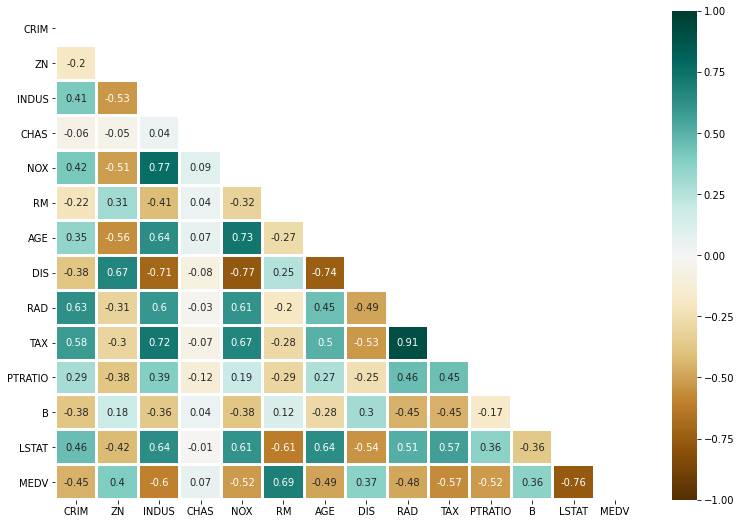

In [322]:
correlation = df.corr()

fig = plt.figure(figsize=(13, 9))
mask = np.triu(np.ones(correlation.shape)).astype(bool)
sns.heatmap(correlation.round(2), mask=mask, annot=True, cmap='BrBG',
            vmin=-1, vmax=1, center= 0, linewidths=2, linecolor='white')
plt.show()

Remember, our target is the median price **MEDV** ! So we need to read the last line of our table.<br/>

We can observe that **the target is highly and positively correlated to the RM** feature (the average number of rooms per dwelling) and it looks normal as the more a dwelling has rooms, the more its price is.<br/>

On the other hand, we see that **the target is highly and negatively correlated to the LSTAT** feature (% lower status of the population) ... houses prices are lower when the amount of lower status people increase.

**Given these observations, I will keep RM and LSTAT features for analysis as they are the two most correlated to our target.**

### Data visualization

In [5]:
# setting plots background color
plt.rcParams.update({'axes.facecolor':'#f8fafc'})

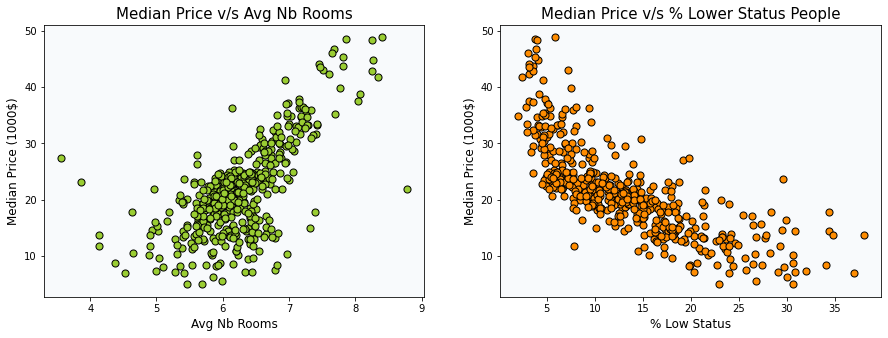

In [6]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(df['RM'], df['MEDV'], c= 'yellowgreen', edgecolor='k', s=50)
plt.xlabel('Avg Nb Rooms', fontsize = 12), plt.ylabel('Median Price (1000$)', fontsize = 12)
plt.title('Median Price v/s Avg Nb Rooms', fontsize = 15)

plt.subplot(122)
plt.scatter(df['LSTAT'], df['MEDV'], c= 'darkorange', edgecolor='k', s=50)
plt.xlabel('% Low Status', fontsize = 12), plt.ylabel('Median Price (1000$)', fontsize = 12)
plt.title('Median Price v/s % Lower Status People', fontsize = 15)
plt.show()

Except for few points, the median price looks approximately linearly correlated to our features ! For a first approach, let's consider the hypothesis of a linear correlation between the target MEDV and features RM and LSTAT.

### 3D data visualization

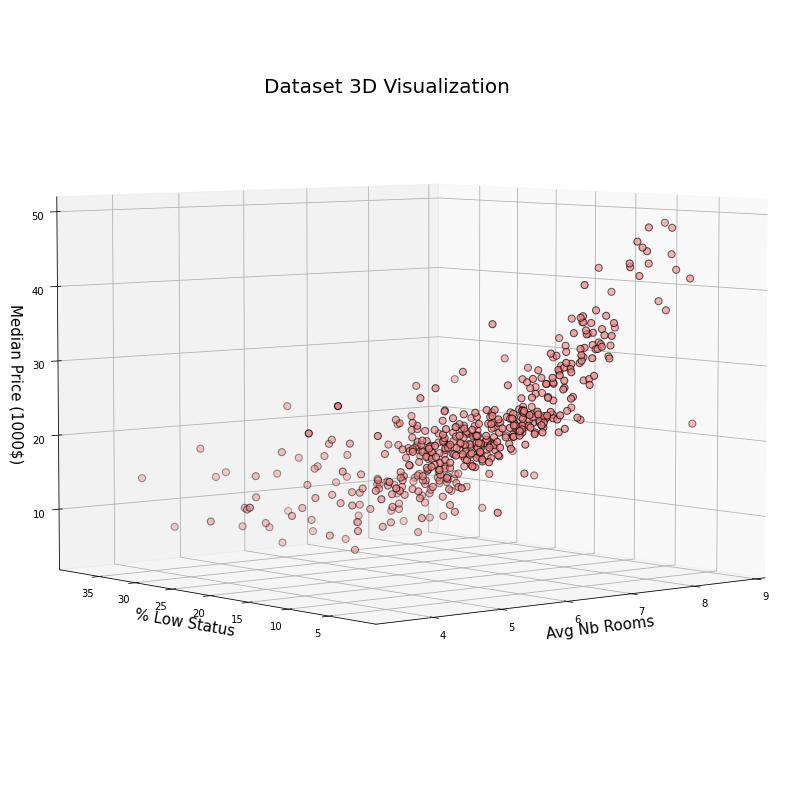

In [220]:
# interactive plot:  %matplotlib notebook
# normal mode plot:  %matplotlib inline

plt.rcParams.update({'axes.facecolor':'white'})

fig = plt.figure(figsize=(14, 14))
fig.suptitle('Dataset 3D Visualization', fontsize=20)
fig.subplots_adjust(top=1.2)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Avg Nb Rooms', fontsize = 15)
ax.set_ylabel('% Low Status', fontsize = 15)
ax.set_zlabel('Median Price (1000$)', fontsize = 15)

u1 = np.array(df['RM'])
u2 = np.array(df['LSTAT'])
v = np.array(df['MEDV'])

ax.scatter(u1, u2, v, color='lightcoral', edgecolor='k', s=50)

ax.elev, ax.azim = 5, -130

plt.show()

## 2.Multiple-Linear model definition

In statistics, multiple linear regression is a mathematical regression method extending simple linear regression to describe the variations of an endogenous variable associated with the variations of several exogenous variables.
 
See: <a href="https://domsdev.github.io/Data-science-blog/post/a_simple_linear_regression_from_scratch/">A simple linear regression from scratch</a>

For a given sequence of **m** observations, as we consider two features from our data

${(x_{1 i}, x_{2 i}, y_i) \hspace{4mm}i=1 ..., m}$

$ y_i=\beta_{0} +\beta_{1}.x_{1 i} +\beta_{2}.x_{2 i} + \epsilon_i $

$ Using \hspace{3mm}matrix \hspace{3mm}notations \hspace{3mm}x_1 = [x_{1 1}, x_{1 2}, ..., x_{1 m}]^T \hspace{3mm}x_2 = [x_{2 1}, x_{2 2}, ..., x_{2 m}]^T \hspace{3mm}$

$and \hspace{3mm}  y = [y_1, y_2, ..., y_m]^T$

$The \hspace{3mm}model \hspace{3mm}is:\hspace{3mm} y = X.\beta + \epsilon$

$Where\hspace{3mm} X = [1 \hspace{3mm} x_{1}\hspace{3mm} x_{2}] \hspace{3mm}and\hspace{3mm} \beta= [\beta_{0} \hspace{3mm}\beta_{1}\hspace{3mm}\beta_{2}]^T$

### Converting data into arrays

In [7]:
x1 = df['RM'].values.reshape(-1, 1)
x2 = df['LSTAT'].values.reshape(-1, 1)
y = df['MEDV'].values.reshape(-1, 1)
print(x1.shape, x2.shape, y.shape)

(490, 1) (490, 1) (490, 1)


Adding identity column vector to features:

In [8]:
X = np.hstack((x1, x2))
X = np.hstack((np.ones(x1.shape), X))
print(X[0:5])

[[1.    6.575 4.98 ]
 [1.    6.421 9.14 ]
 [1.    7.185 4.03 ]
 [1.    6.998 2.94 ]
 [1.    7.147 5.33 ]]


### Defining model

In [9]:
def model(X, Beta):
    return X.dot(Beta)

### Parameters initialization

In [10]:
np.random.seed(50)
Beta = np.random.randn(3, 1)
print(Beta)

[[-1.56035211]
 [-0.0309776 ]
 [-0.62092842]]


### Checking  model's initial state by visualizing the regression plane

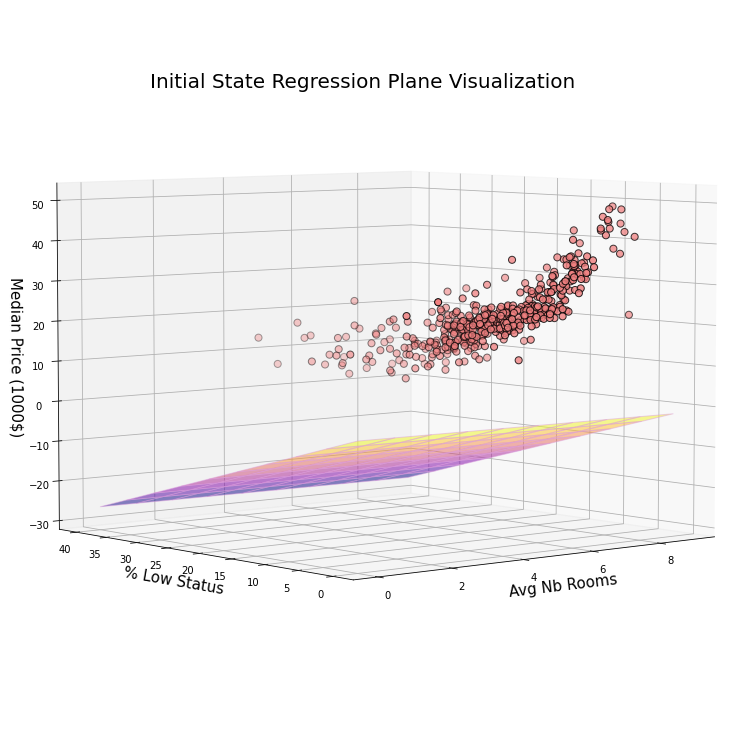

In [11]:
%matplotlib inline
plt.rcParams.update({'axes.facecolor':'white'})

fig = plt.figure(figsize=(13, 13))
fig.suptitle('Initial State Regression Plane Visualization', fontsize=20)
fig.subplots_adjust(top=1.2)

ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Avg Nb Rooms', fontsize = 15)
ax.set_ylabel('% Low Status', fontsize = 15)
ax.set_zlabel('Median Price (1000$)', fontsize = 15)

# Dataset plot
u1 = np.array(df['RM'])
u2 = np.array(df['LSTAT'])
v = np.array(df['MEDV'])
ax.scatter(u1, u2, v, color='lightcoral', edgecolor='k', s=50)

# Hyperplane regression plot
u1 = np.linspace(0,9,10)
u2 = np.linspace(0,40,10)
u1, u2 = np.meshgrid(u1, u2)
v = Beta[0] + Beta[1]*u1 + Beta[2]*u2
ax.plot_surface(u1, u2, v, alpha=0.5, cmap='plasma', edgecolor='plum')

ax.elev, ax.azim = 5, -130
plt.show()

One clearly see on plot that the model is not fitted yet to our data !

## 3.Loss function : Mean Squared Error (MSE)

To measure the error of our model we define the Loss function as the mean of the squares of the residuals:

$ J(\beta) = \frac{1}{m} \sum (y - X.\beta)^2 $

In [12]:
def lossFunction(X, y, Beta):
        m = y.shape[0]
        return 1/(m) * np.sum((model(X, Beta) - y)**2)

Let's check the initial Loss value:

In [13]:
lossFunction(X, y, Beta)

1015.5676625443134

## 4.Gradient definition

$\frac{\partial J(\beta) }{\partial \beta} = - \frac{2}{m} X^T.(y - X.\beta)$

But as we want to solve a minimization problem, we keep for calculations the gradient multiplied by -1:

In [14]:
def gradient(X, y, Beta):
    m = y.shape[0]
    return 2/m * X.T.dot(model(X, Beta) - y)

## 5.Gradient descent algorithm

$\beta' = \beta - \alpha \frac{\partial J(\beta) }{\partial \beta}$

In [15]:
def gradientDescent(X, y, Beta, learning_rate, n_iterations):
    loss_history = np.zeros(n_iterations)
    for i in range(n_iterations):
        Beta = Beta - learning_rate * gradient(X, y, Beta)
        loss_history[i] = lossFunction(X, y, Beta)
    
    return Beta, loss_history

## 6.Training the model on data

First I define the hypermarameters:

In [16]:
N_ITERATIONS = 500
LEARNING_RATE = 0.001

Then I train the model on the data...

In [17]:
Final_Beta, loss_history = gradientDescent(X, y, Beta, LEARNING_RATE, N_ITERATIONS)

...so I can get the regression coefficients.

In [18]:
print(f"Intercept = {Final_Beta[0][0]:.2f}")
print(f"coefficient 1 = {Final_Beta[1][0]:.2f}")
print(f"coefficient 2 = {Final_Beta[2][0]:.2f}")

Intercept = -0.87
coefficient 1 = 4.78
coefficient 2 = -0.57


Let's have a look on the Learning Curve:

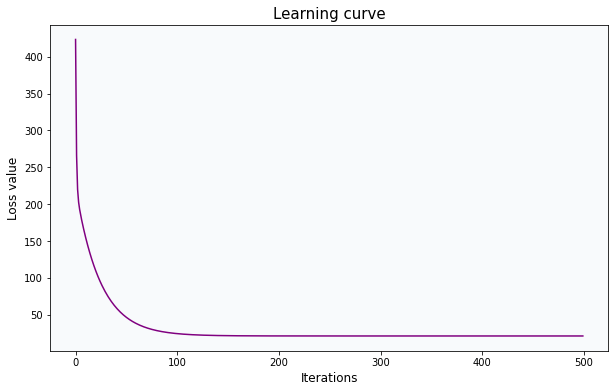

In [19]:
plt.rcParams.update({'axes.facecolor':'#f8fafc'})
plt.figure(figsize=(10,6))
plt.plot(range(N_ITERATIONS), loss_history, c= 'purple')
plt.title('Learning curve', fontsize = 15)
plt.xlabel('Iterations', fontsize = 12)
plt.ylabel('Loss value', fontsize = 12)
plt.show()

## 7.Model evaluation

### Regression plane visualization

Let's create a 3D plot animation for better visualization:

In [219]:
from matplotlib import animation

plt.rcParams.update({'axes.facecolor':'white'})
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(projection='3d')
fig.suptitle('Final Regression Plane Visualization', fontsize=20)
fig.subplots_adjust(top=1.1)

ax.set_xlabel('Avg Nb Rooms', fontsize = 15)
ax.set_ylabel('% Low Status', fontsize = 15)
ax.set_zlabel('Median Price (1000$)', fontsize = 15)
plt.close()

def init():
    # Dataset plot
    u1 = np.array(df['RM'])
    u2 = np.array(df['LSTAT'])
    v = np.array(df['MEDV'])
    ax.scatter(u1, u2, v, color='lightcoral', edgecolor='k', s=50)
    
    # Regression plane plot
    u1 = np.linspace(0,9,20)
    u2 = np.linspace(0,40,20)
    u1, u2 = np.meshgrid(u1, u2)
    v = Final_Beta[0] + Final_Beta[1]*u1 + Final_Beta[2]*u2
    ax.plot_surface(u1, u2, v, alpha=0.3, cmap='plasma', edgecolor='plum')
    
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Creating the animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=40, blit=True)

# Saving the animation
anim.save('igm/animation1.gif', fps=25)

![Alt Text](img/animation1.gif)

The regression plane seems to fit pretty good on median prices lower than 40000 Dollars, But not so good for higher values ! It fits badly as well for median prices where the percentage of low status people is high. <br/>

**The model could be too simple to well modelize the data.**

### Coefficient of determination

Coefficient values between [0, 1].  Indicates the quality of the prediction.

$ R^2 = 1 - \frac{\sum ((y_i - \hat{y_i})^2}{\sum ((y_i - \bar{y})^2)} $

In [20]:
def determinationCoef(y, y_pred):
    SSR = ((y - y_pred)**2).sum()    # Residual sum of squares SSR
    SST = ((y - y.mean())**2).sum()  # Total sum of squares SST
    return np.sqrt(1 - SSR/SST)

In [21]:
y_prediction = model(X, Final_Beta)
print(f"R2 = {determinationCoef(y, y_prediction):0.2f}")

R2 = 0.81


The R2 coefficient is quite high, but far from the maximum value.<br/>

**This confirms what we can see on graphics: the model must be too simple... So let's try to improve it !**

## 8.Multiple Polynomial Regression

**This time we will consider a non linear - polynomial correlation between the median price value and the percentage of lower status people feature.**

![png](img/feature_plots.png)

Polynomial regression is a form of regression analysis in which the relationship between the independent variable x and the dependent variable y is modelled as an nth degree polynomial in x.
Polynomial regression fits a nonlinear relationship between the value of x and the corresponding conditional mean of y. Although polynomial regression fits a nonlinear function of the data, as a statistical estimation problem it is linear, in the sense that the regression model is linear to the unknown parameters that are estimated from the data. For this reason, polynomial regression is considered to be a special case of multiple linear regression.

**The regression model remains linear to the unknown parameters:**

$ y = X.\beta + \epsilon$

**... but polynomial regression fits a nonlinear function of the features:**

$ y_i=\beta_{0} +\beta_{1}.x_{1 i} +\beta_{2}.x_{2 i} +\beta_{3}.x_{1 i}.x_{2 i} +\beta_{4}.x_{2 i}^2 + \epsilon_i $

### Converting data into arrays

In [22]:
x1 = df['RM'].values.reshape(-1, 1)
x2 = df['LSTAT'].values.reshape(-1, 1)
y = df['MEDV'].values.reshape(-1, 1)
print(x1.shape, x2.shape, y.shape)

(490, 1) (490, 1) (490, 1)


### Here we need to scale our data in order to avoid memory overflow !!

Calculations without scaling brings too high values ...

![png](img/overflow_encountered.png)

I used the sklearn MinMaxScaler preprocessing to scale the data:<br/>

$X_{scaled} = X_{std} * (max - min) + min$<br/>

where <br/>

$X_{std} = (X - X_{min}) / (X_{max} - X_{min})$

In [23]:
from sklearn.preprocessing import MinMaxScaler
RM_scaler = MinMaxScaler([-1,1])
LSTAT_scaler = MinMaxScaler([-1,1])
MEDV_scaler = MinMaxScaler([-1,1])

x1 = RM_scaler.fit_transform(x1)
x2 = LSTAT_scaler.fit_transform(x2)
y = MEDV_scaler.fit_transform(y)

Now we need to add identity and non-linear terms column vector features:

$X = [1 \hspace{3mm} x_1 \hspace{3mm} x_2 \hspace{3mm} x_1.x_2 \hspace{3mm} x_2^2]$

In [24]:
X = np.hstack((x1, x2))
X = np.hstack((X, x1*x2))
X = np.hstack((X, x2**2))
X = np.hstack((np.ones(x1.shape), X))
print(X[0:5])

[[ 1.          0.15501054 -0.83328702 -0.12916827  0.69436726]
 [ 1.          0.0959954  -0.6021117  -0.05779995  0.3625385 ]
 [ 1.          0.3887718  -0.88607947 -0.34448271  0.78513682]
 [ 1.          0.31711056 -0.94665185 -0.3001933   0.89614972]
 [ 1.          0.37420962 -0.81383718 -0.3045457   0.66233095]]


### Time for hyperparameters initialization:

In [25]:
np.random.seed(50)
Beta = np.random.randn(5, 1)
print(Beta)

[[-1.56035211]
 [-0.0309776 ]
 [-0.62092842]
 [-1.46458049]
 [ 1.41194612]]


### Ok now we can check model's initial state by visualizing the 3D regression surface

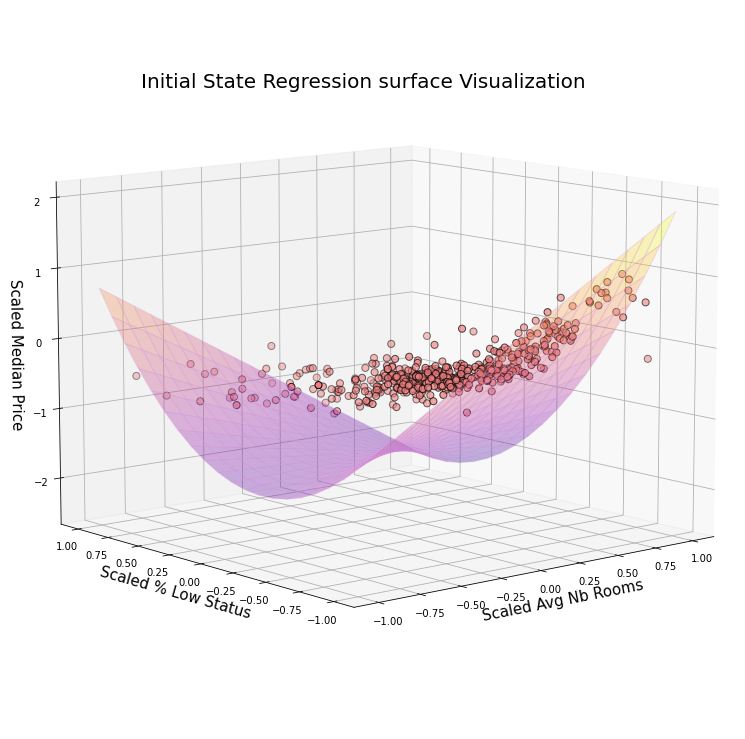

In [26]:
%matplotlib inline
plt.rcParams.update({'axes.facecolor':'white'})

fig = plt.figure(figsize=(13, 13))
fig.suptitle('Initial State Regression surface Visualization', fontsize=20)
fig.subplots_adjust(top=1.2)

ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Scaled Avg Nb Rooms', fontsize = 15)
ax.set_ylabel('Scaled % Low Status', fontsize = 15)
ax.set_zlabel('Scaled Median Price', fontsize = 15)

# Dataset plot
ax.scatter(x1, x2, y, color='lightcoral', edgecolor='k', s=50)

# Regression surface plot
u1 = np.linspace(-1,1,20)
u2 = np.linspace(-1,1,20)
u1, u2 = np.meshgrid(u1, u2)
v = Beta[0] + Beta[1]*u1 + Beta[2]*u2  + Beta[3]* u1*u2 + Beta[4]* u2**2
ax.plot_surface(u1, u2, v, alpha=0.3, cmap='plasma', edgecolor='plum')

ax.elev, ax.azim = 10, -130
plt.show()

Perfect ! We can see that the regression surface is far from the dataset points. It's time to train our polynomial regression model.

### Let's launch the train ...

In [27]:
N_ITERATIONS = 50000
LEARNING_RATE = 0.01

Final_Beta, loss_history = gradientDescent(X, y, Beta, LEARNING_RATE, N_ITERATIONS)
print(Final_Beta)

[[-0.54169521]
 [ 0.00731156]
 [-0.62805316]
 [-1.00386475]
 [-0.05360365]]


### ... and visualize the updated regression surface !

In [184]:
%matplotlib inline
plt.rcParams.update({'axes.facecolor':'white'})

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(projection='3d')
fig.suptitle('Final Regression surface Visualization', fontsize=20)
fig.subplots_adjust(top=1.1)

ax.set_xlabel('Scaled Avg Nb Rooms', fontsize = 15)
ax.set_ylabel('Scaled % Low Status', fontsize = 15)
ax.set_zlabel('Scaled Median Price', fontsize = 15)
plt.close()

def init():
    # Dataset plot
    ax.scatter(x1, x2, y, color='lightcoral', edgecolor='k', s=50)
    
    # Regression surface plot
    u1 = np.linspace(-1,1,20).reshape(-1,1)
    u2 = np.linspace(-1,1,20).reshape(-1,1)
    u1, u2 = np.meshgrid(u1, u2)
    v = Final_Beta[0] + Final_Beta[1]*u1 + Final_Beta[2]*u2  + Final_Beta[3]* u1*u2 + Final_Beta[4]* u2**2
    
    ax.plot_surface(u1, u2, v, alpha=0.3, cmap='plasma', edgecolor ='plum')
    
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Creating the animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=40, blit=True)

# Saving the animation
anim.save('igm/animation2.gif', fps=25)

![Alt Text](img/animation2.gif)

Great !! This regression surface fits our data much better than previously with the multiple linear regression model.

### Coefficient of determination

In [28]:
y_prediction = model(X, Final_Beta)
print(f"R2 = {determinationCoef(y, y_prediction):0.2f}")

R2 = 0.87


We see that for this model, the coefficient of determination is really better, in addition to the fact that the regression surface adapts quite well to our data!

## 9. Median houses prices Estimations

**Ok, now that we have a quite good model, let's try to do what we are here for : make some estimations.**

Imagine that new data incoming ... we get new lines in our dataframe, and it reveals that:<br/>

In [29]:
import tabulate
data_new = {'RM': [4, 8], 'LSTAT': [35, 6], 'MEDV': ['estimation ?', 'estimation ?']}
df_new = pd.DataFrame(data=data_new)
print(df_new.to_markdown())

|    |   RM |   LSTAT | MEDV         |
|---:|-----:|--------:|:-------------|
|  0 |    4 |      35 | estimation ? |
|  1 |    8 |       6 | estimation ? |


**Now, as it is our goal, we want to estimate the median price value (MEDV) for these new data!**<br/>

So let's convert our data into arrays:

In [30]:
x1_new_data = np.array([4, 8]).reshape(-1,1)
x2_new_data = np.array([30, 6]).reshape(-1,1)

To do the prediction calculation, we need to go in the scaled space !

In [31]:
x1_new = RM_scaler.transform(x1_new_data)
x2_new = LSTAT_scaler.transform(x2_new_data)

Then add identity and non-linear terms column vector to features as usual ...

In [32]:
X = np.hstack((x1_new, x2_new))
X = np.hstack((X, x1_new*x2_new))
X = np.hstack((X, x2_new**2))
X = np.hstack((np.ones(x1_new.shape), X))
print(X)

[[ 1.         -0.83176854  0.55709919 -0.46337758  0.31035951]
 [ 1.          0.70109216 -0.77660461 -0.54447141  0.60311472]]


So we can estimate a scaled median price:

In [33]:
y_prediciton_scaled = model(X, Final_Beta)

... and go back to real values using the **inverse scaling transformation** !

In [34]:
y_prediciton = MEDV_scaler.inverse_transform(y_prediciton_scaled)
print(f"The estimated median price for (RM=4,LSTAT=35) is {y_prediciton[0][0]*1000:.0f} Dollars !")
print(f"The estimated median price for (RM=8,LSTAT=6) is {y_prediciton[1][0]*1000:.0f} Dollars !")

The estimated median price for (RM=4,LSTAT=35) is 17064 Dollars !
The estimated median price for (RM=8,LSTAT=6) is 37093 Dollars !


To finally report the estimated median price values on plots:

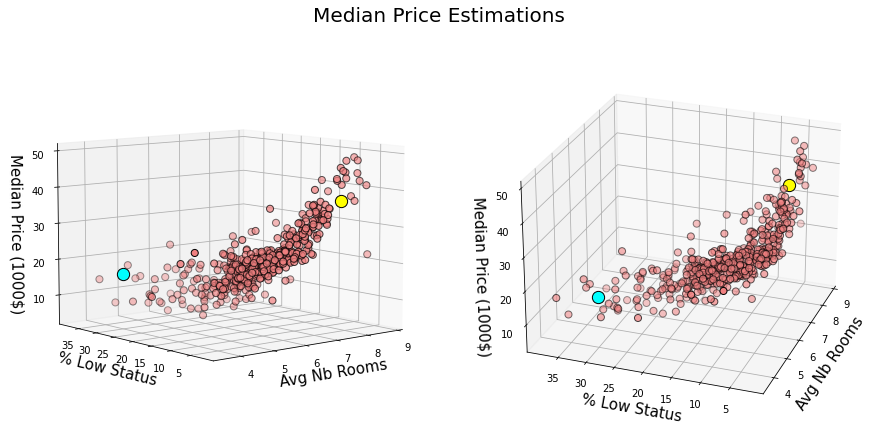

In [35]:
%matplotlib inline
plt.rcParams.update({'axes.facecolor':'white'})

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Median Price Estimations', fontsize=20)
fig.subplots_adjust(top=1.4)

# VIEW 1
ax = fig.add_subplot(121, projection='3d')
ax.set_xlabel('Avg Nb Rooms', fontsize = 15)
ax.set_ylabel('% Low Status', fontsize = 15)
ax.set_zlabel('Median Price (1000$)', fontsize = 15)
ax.elev, ax.azim = 8, -130

# Dataset plot
u1 = np.array(df['RM'])
u2 = np.array(df['LSTAT'])
v = np.array(df['MEDV'])
ax.scatter(u1, u2, v, color='lightcoral', edgecolor='k', s=50)

# Prediction plot
ax.scatter(x1_new_data[0], x2_new_data[0], y_prediciton[0][0], color='aqua', edgecolor='k', s=150)
ax.scatter(x1_new_data[1], x2_new_data[1], y_prediciton[1][0], color='yellow', edgecolor='k', s=150)


# VIEW 2
ax = fig.add_subplot(122, projection='3d')
ax.set_xlabel('Avg Nb Rooms', fontsize = 15)
ax.set_ylabel('% Low Status', fontsize = 15)
ax.set_zlabel('Median Price (1000$)', fontsize = 15)
ax.elev, ax.azim = 25, -160

# Dataset plot
u1 = np.array(df['RM'])
u2 = np.array(df['LSTAT'])
v = np.array(df['MEDV'])
ax.scatter(u1, u2, v, color='lightcoral', edgecolor='k', s=50)

# Prediction plot
ax.scatter(x1_new_data[0], x2_new_data[0], y_prediciton[0][0], color='aqua', edgecolor='k', s=150)
ax.scatter(x1_new_data[1], x2_new_data[1], y_prediciton[1][0], color='yellow', edgecolor='k', s=150)

plt.show()

# 10.Conclusion

I built a multiple linear regression model from scratch to estimate the average house price from the Boston data set. The model was pretty good but needed to be improved ... Then I built a multiple polynomial regression model to better fit the data, and this model gave even better results:<br/>

**Multiple Linear regression model:  R2 = 81<br/>**


**Multiple Polynomial regression model: R2 = 87**

**Now we have a tool which can help Boston City's real estate agencies to estimate the median house price as a support for their business activity.**